<a href="https://colab.research.google.com/github/MRathmair/Haiku/blob/main/haiku_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch data

In [1]:
import os

filename = "lines.txt"
url = "https://raw.githubusercontent.com/MRathmair/Haiku/refs/heads/main/lines.txt"

if not os.path.exists(filename):
    print(f"Downloading {filename}...")
    !wget {url}
else:
    print(f"{filename} already exists. Skipping download.")

lines.txt already exists. Skipping download.


In [2]:
with open("lines.txt", "r") as file:
    lines = file.readlines()          # reads the .txt line by line -> list of strings

for k in range(len(lines)):
  lines[k] = lines[k].replace("$","").replace("/", "<LINE1>",1).replace("/","<LINE2>",1)

In [3]:
import random

for _ in range(5):
  print(random.choice(lines))

plants are phoenixes <LINE1> burst bloom blaze bend break burn be <LINE2> so feeds its next self 

strike click boom <LINE1> roadblock lead to buildups <LINE2> build ups lead to explosive force 

prance delightfully <LINE1> then give me aids mightily <LINE2> male ballerinas 

could have would have all <LINE1> but no desire to persist <LINE2> outcome is nothing 

whisper quietly <LINE1>  or they may hear the secret <LINE2>  meant only for me 



# Preprocess data

## Tokenize

In [4]:
# lines -> lines_upd.txt for tokenizer trainer
with open("lines_upd.txt", "w") as file:
    for line in lines:
        file.write(line)

In [5]:
import sentencepiece as spm

# Trains tokenizer
spm.SentencePieceTrainer.train(
    input='lines_upd.txt',
    model_prefix='bpe',
    vocab_size=2000,
    model_type='bpe',
    user_defined_symbols = ["<s>", "</s>", "<pad>", "<LINE1>", "<LINE2>"]
)

# Load the trained SentencePiece model
sp = spm.SentencePieceProcessor(model_file='bpe.model')

In [6]:
input = random.choice(lines)
print(input)
print(sp.encode(input, out_type=str))
print(sp.encode(input))

orange auburn red <LINE1> piled like snow on curbs cars <LINE2> damp autumn blanket 

['▁orange', '▁a', 'ub', 'urn', '▁red', '▁', '<LINE1>', '▁p', 'iled', '▁like', '▁snow', '▁on', '▁cur', 'b', 's', '▁c', 'ars', '▁', '<LINE2>', '▁dam', 'p', '▁autumn', '▁blank', 'et']
[1812, 9, 944, 300, 411, 1972, 4, 30, 1952, 163, 435, 64, 769, 1992, 1978, 21, 192, 1972, 5, 915, 1991, 737, 1133, 51]


## Dataloader for training and testing

In [7]:
#transform lines to a list of integer sequences
haikus_encoded = []
for line in lines:
  to_append = [sp.piece_to_id("<s>")] + sp.encode(line) + [sp.piece_to_id("</s>")]
  haikus_encoded.append(to_append)

print(random.choice(haikus_encoded))

[1, 9, 429, 504, 790, 1974, 1983, 182, 1972, 4, 100, 9, 469, 1985, 220, 376, 45, 1972, 5, 9, 30, 1047, 422, 53, 693, 2]


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

class MyDataset(Dataset):
    def __init__(self, seqlist):
        self.data = seqlist

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long)

def collate_fn(batch):
    return pad_sequence(batch, batch_first=True, padding_value=sp.piece_to_id("<pad>"))

dataset = MyDataset(haikus_encoded)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

print(len(dataset), len(train_dataset), len(test_dataset))

11269 9016 2253


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Model building

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
MAX_LEN = max([len(seq) for seq in haikus_encoded])
print("MAX_LEN = ", MAX_LEN)

D_MODEL = 256
D_HEAD = 64
NUM_HEADS = D_MODEL//D_HEAD
D_FF = 2*D_MODEL

NUM_BLOCKS = 4

VOCAB_SIZE = sp.get_piece_size()
print("VOCAB_SIZE = ", VOCAB_SIZE)

MAX_LEN =  42
VOCAB_SIZE =  2000


In [12]:
import torch.nn as nn

def PEMatrix(d_model, max_len):
  pe = torch.zeros(max_len, d_model)
  pos = torch.arange(0,max_len)
  exp = -torch.arange(0,d_model,2)/d_model

  pe[:, 0::2] = torch.sin(torch.outer(pos, 10000**exp))
  pe[:, 1::2] = torch.cos(torch.outer(pos, 10000**exp))

  return pe


class PosEmbedding(nn.Module):
  def __init__(self, d_model=D_MODEL, vocab_size = VOCAB_SIZE, max_len=MAX_LEN):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.register_buffer("pe", PEMatrix(d_model, max_len))  #-> (max_len, d_model)

  def forward(self, x):
    # shape of x -> (BATCH, LENGTH, D_MODEL)
    L = x.shape[1]
    return self.embedding(x) + self.pe[:L,:].unsqueeze(0)

In [13]:
def masked_attention(Q,K,V):
  #shape of q,k,v = (BATCH, SEQ_LEN, d_q=d_k or d_v, resp.)
  d_k = torch.tensor(K.shape[-1])
  seq_len = K.shape[1]

  mask = (torch.tril(torch.ones(seq_len,seq_len))==0).to(device)

  scores = torch.matmul(Q,K.transpose(-2,-1))/torch.sqrt(d_k)  # (BATCH, SEQ_LEN, SEQ_LEN)
  scores = scores.masked_fill(mask, float("-inf"))
  probabs = torch.softmax(scores, dim=-1)

  return torch.matmul(probabs,V)   #output shape -> (BATCH, SEQ_LEN, d_v)

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model=D_MODEL, n_heads=NUM_HEADS):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model//n_heads

    self.W_Q = nn.ModuleList([nn.Linear(self.d_model, self.d_head, bias = False) for _ in range(self.n_heads)])
    self.W_K = nn.ModuleList([nn.Linear(self.d_model, self.d_head, bias = False) for _ in range(self.n_heads)])
    self.W_V = nn.ModuleList([nn.Linear(self.d_model, self.d_head, bias = False) for _ in range(self.n_heads)])

    self.W_O = nn.Linear(n_heads*self.d_head, d_model)

  def forward(self, x):
    heads = []
    for WQ,WK,WV in zip(self.W_Q, self.W_K, self.W_V):
      heads.append(masked_attention(WQ(x), WK(x), WV(x)))

    return self.W_O(torch.cat(heads, dim=-1))

class DecoderBlock(nn.Module):
  def __init__(self, d_model=D_MODEL, n_heads=NUM_HEADS, d_ff = D_FF, dropout=0.2):
    super().__init__()

    self.attentionblock = MultiHeadAttention(d_model, n_heads)
    self.norm1 = nn.LayerNorm(d_model)
    self.feedforward = nn.Sequential(
        nn.Linear(d_model, d_ff),
        nn.ReLU(),
        nn.Linear(d_ff, d_model)
    )
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.norm1(x + self.dropout(self.attentionblock(x)))
    return self.norm2(x + self.dropout(self.feedforward(x)))

In [14]:
class Decoder(nn.Module):
  def __init__(self, num_blocks=NUM_BLOCKS, d_model=D_MODEL, n_heads=NUM_HEADS, vocab_size = VOCAB_SIZE, max_len = MAX_LEN, d_ff = D_FF, dropout=0.2):
    super().__init__()

    self.embedding = PosEmbedding(d_model, vocab_size, max_len)
    self.blocks = nn.ModuleList([DecoderBlock(d_model, n_heads, d_ff, dropout) for _ in range(num_blocks)])
    self.linear = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    x = self.embedding(x)
    for block in self.blocks:
      x = block(x)
    return self.linear(x)

  def predict_next_token(self, seq_of_tokens, temperature = 0.2):
    self.eval()
    x = torch.tensor(seq_of_tokens, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
      logits = self(x)[0][-1] / temperature
      probabs = torch.softmax(logits, dim=-1)
      return torch.multinomial(probabs, 1).item()

# Training

In [15]:
# device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
def train_step(model, dataloader, loss_fn, optimizer, device=device):
  model.train()
  total_loss = 0

  for batch in dataloader:
    input = batch[:,:-1].to(device)
    target = batch[:,1:].to(device)

    logits = model(input)
    loss = loss_fn(logits.reshape(-1,logits.shape[-1]), target.reshape(-1))
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return total_loss / len(dataloader.dataset)

In [17]:
def test_step(model, dataloader, loss_fn, device=device):
  model.eval()
  loss = 0

  with torch.no_grad():
    for batch in dataloader:
      input = batch[:,:-1].to(device)
      target = batch[:,1:].to(device)

      logits = model(input)
      loss += loss_fn(logits.reshape(-1,logits.shape[-1]), target.reshape(-1))

  return loss.item() / len(dataloader.dataset)

In [18]:
from pathlib import Path

def save_model(model, filename="bestmodel.pth"):
  torch.save(model.state_dict(), filename)

In [19]:
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn as nn

def train_and_test(model, epochs = 25, learn_rate = 0.0001):

  model = model.to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr = learn_rate)

  train_loss, test_loss = [], []
  for epoch in range(epochs):
    train_loss.append(train_step(model, train_dataloader, loss_fn, optimizer))
    test_loss.append(test_step(model, test_dataloader, loss_fn))

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss[-1]:.6f} | Test Loss: {test_loss[-1]:.6f}")

    if test_loss[-1]<= min(test_loss):
      save_model(model)
      print("-> Model saved!") # saving the model with the best test performance


  plt.plot(train_loss, label="Train Loss")
  plt.plot(test_loss, label="Test Loss")
  plt.legend()
  plt.show()

  return {"train_losses": train_loss, "test_losses": test_loss}


Epoch 1/30 | Train Loss: 0.142315 | Test Loss: 0.132520
-> Model saved!
Epoch 2/30 | Train Loss: 0.127344 | Test Loss: 0.126474
-> Model saved!
Epoch 3/30 | Train Loss: 0.120985 | Test Loss: 0.121025
-> Model saved!
Epoch 4/30 | Train Loss: 0.116025 | Test Loss: 0.117296
-> Model saved!
Epoch 5/30 | Train Loss: 0.111931 | Test Loss: 0.114629
-> Model saved!
Epoch 6/30 | Train Loss: 0.109181 | Test Loss: 0.112291
-> Model saved!
Epoch 7/30 | Train Loss: 0.106223 | Test Loss: 0.110541
-> Model saved!
Epoch 8/30 | Train Loss: 0.103469 | Test Loss: 0.109034
-> Model saved!
Epoch 9/30 | Train Loss: 0.101627 | Test Loss: 0.107791
-> Model saved!
Epoch 10/30 | Train Loss: 0.099777 | Test Loss: 0.106701
-> Model saved!
Epoch 11/30 | Train Loss: 0.098197 | Test Loss: 0.105913
-> Model saved!
Epoch 12/30 | Train Loss: 0.096736 | Test Loss: 0.105712
-> Model saved!
Epoch 13/30 | Train Loss: 0.095268 | Test Loss: 0.104870
-> Model saved!
Epoch 14/30 | Train Loss: 0.094396 | Test Loss: 0.104246
-> 

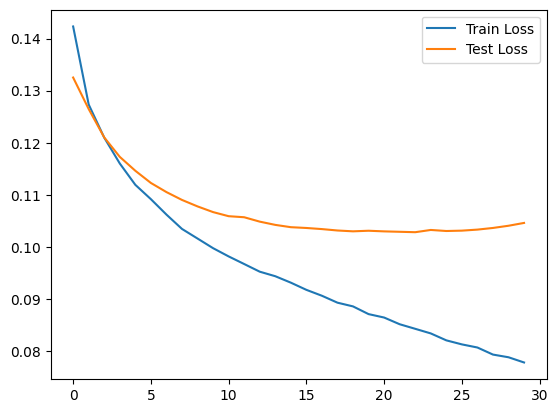

Training time: 243.67 seconds


In [20]:
import time
model = Decoder()

start = time.time()
loss_dict = train_and_test(model, epochs=30)
end = time.time()
print("----------------------------------")
print(f"Training time: {end-start:.2f} seconds")

# Generate new haikus

In [21]:
print(device)

cuda


In [22]:
def generate_haiku(model, sp, device = device):
  model.to(device)

  last_id = sp.piece_to_id("<s>")
  seq = [last_id]

  while (last_id != sp.piece_to_id("</s>") and len(seq)< MAX_LEN):
    next_id = model.predict_next_token(seq, temperature = 0.5)
    seq.append(next_id)
    last_id = next_id

  return seq

In [23]:
#load model which performed best on test data
loaded_model = Decoder().to(device)
loaded_model.load_state_dict(torch.load("bestmodel.pth"))

<ipython-input-23-ed157a6ed9b6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("bestmodel.pth"))


<All keys matched successfully>

In [24]:
#generate a bunch of haikus
for _ in range(25):
  new_haiku = sp.decode(generate_haiku(loaded_model, sp))
  new_haiku = new_haiku.replace("<LINE1>", "\n").replace("<LINE2>", "\n").replace("<s>", "").replace("</s>", "")
  print(new_haiku)
  print("--------------------")

 a man in a park 
 i'm not a constantly 
 i'm not to be
--------------------
 a dreaming of a 
 yet to crioria 
 a new world is it
--------------------
 you're like a lighter 
 don't mean to be a bulls 
 i will be a relief
--------------------
 i miss the sun stuff 
 it's what i'm not a haiku 
 that's a haiku
--------------------
 it's the way i'm not 
 i'll never been this day 
 i'm not this haiku
--------------------
 i'm a haiku is 
 i'm sorry it all to me 
 i'm not cyany
--------------------
 the sun shines brightly 
 flame like a fuels in the 
 a crowd of spring
--------------------
 i am not okay 
 our love for the same lacking 
 i am not to you
--------------------
 a bird of youth 
 a view of bash of darkness 
 a rumbling of spring
--------------------
 annoying insect 
 the trees is not evening 
 i can feel like you
--------------------
 i lay in my arms 
 i am in the ocean of 
 i miss you my love
--------------------
 i'm a mad taken 
 i'm in the campolation 
 i'm not to be f